# Project 3 - BD Analytics

In [7]:
from pyspark.context import SparkContext # for RDDs
from pyspark.sql import SparkSession # for DFs

spark = (SparkSession.builder
                    .appName('BDM_project3')
                    .getOrCreate()
        ) # for DFs

## Importing the data

In [8]:
# Reading in all the files
#files = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]
files = ["dblp-ref-3.json"]

papers_df = (spark.read
             .option("inferSchema", True) # Letting Spark itself define the schema
             .json(files) 
            )

papers_df.printSchema()

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)



In [9]:
# Reading in only one file (for testing purposes
'''
papers_df = (spark.read
             .option("inferSchema", True) # Letting Spark itself define the schema
             .json("dblp-ref-3.json")
            )

papers_df.printSchema()
'''

'\npapers_df = (spark.read\n             .option("inferSchema", True) # Letting Spark itself define the schema\n             .json("dblp-ref-3.json")\n            )\n\npapers_df.printSchema()\n'

## Exploratory data analysis

In [10]:
# Subset of the dataframe
papers_df.show(5)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|AdaBoost algorith...|[Zheng Xu, Runbin...|001eef4f-1d00-4ae...|         0|[0a11984c-ab6e-4b...|A Heterogeneous S...|high performance ...|2016|
|In this paper, a ...|[Yufei Liang, Yan...|002e0b7e-d62f-414...|         0|                  []|A novel conformal...|international con...|2016|
|This paper studie...|[Xiaodong Ai, Key...|00352759-f0a7-467...|         0|[1862a08a-08c6-4a...|A source-seeking ...|international con...|2016|
|                NULL|[Francine Berman,...|00f77fa9-ae49-493...|         0|                  []|Social and ethica...|Communications of..

In [11]:
# Shape of the dataframe
print((papers_df.count(), len(papers_df.columns)))

(79007, 8)


In [12]:
# First row
papers_df.show(n=1, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
# Number on NaN values in each column 
# https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

Dict_Null = {col:papers_df.filter(papers_df[col].isNull()).count() for col in papers_df.columns}
Dict_Null

{'abstract': 34037,
 'authors': 0,
 'id': 0,
 'n_citation': 0,
 'references': 29461,
 'title': 0,
 'venue': 0,
 'year': 0}

In [14]:
# Summary statistics (for numeric columns)
papers_df.describe("n_citation", "year").toPandas()

,summary,n_citation,year
0,count,79007,79007
1,mean,7.607566418165479,2014.6681053577531
2,stddev,51.072850795288375,5.485498159474597
3,min,0,1955
4,max,7091,2018


## Data Preprocessing

In [15]:
# Only keeping the English documents

# !pip install langdetect

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from langdetect import detect, LangDetectException
# Only keeping the English documents
def detect_language(text):
    if text:
        try:
            return detect(text)
        except:
            return 'unknown'
    return 'unknown'
detect_language_udf = udf(detect_language, StringType())
papers_df = papers_df.withColumn("language", detect_language_udf(papers_df.abstract))
papers_df = papers_df.filter(papers_df.language == 'en')


In [16]:
# Removing stopwords (with Gensim)
# !pip install gensim
from gensim.parsing.preprocessing import remove_stopwords #!pip install gensim

def remove_stop_words(text):
    if text is not None:
        return remove_stopwords(text)
    return text

In [17]:
# Remove custom stopwords
custom_stop_words = [ 'doi',
'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure','rights',
'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier',
'PMC', 'CZI', 'www']
def remove_custom_stop_words(text):
    if text is not None:
        words = text.split()
        filtered_words = [word for word in words if word not in custom_stop_words]
        return ' '.join(filtered_words)
    return text


In [18]:
# Remove punctuation
import re

def remove_punctuation(text):
    if text is not None:
        return re.sub(r'[!()\[\]{};:\'"\,<>./?@#$%^&*_~]', '', text)
    return text

In [19]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType
from pyspark.sql.functions import lower
from pyspark.sql.functions import regexp_extract, col

# Create a user-defined function (UDF)
remove_stop_words_udf = F.udf(remove_stop_words, StringType()) # Default return type is string
custom_stop_words_udf = F.udf(remove_custom_stop_words, StringType()) # Default return type is string
remove_punctuation_udf = F.udf(remove_punctuation, StringType()) # Default return type is string

# Apply the UDF 
# Remove stop words
papers_df = papers_df.withColumn("abstract", remove_stop_words_udf(papers_df["abstract"]))
papers_df = papers_df.withColumn("title", remove_stop_words_udf(papers_df["title"]))

# Convert into a lowercase
papers_df = papers_df.withColumn('abstract', lower(papers_df['abstract']))
papers_df = papers_df.withColumn('title', lower(papers_df['title']))

# Remove custom stop words
papers_df = papers_df.withColumn("abstract", custom_stop_words_udf(papers_df["abstract"]))
papers_df = papers_df.withColumn("title", custom_stop_words_udf(papers_df["title"]))

# Remove punctuation
papers_df = papers_df.withColumn('abstract', remove_punctuation_udf(papers_df['abstract']))
papers_df = papers_df.withColumn('title', remove_punctuation_udf(papers_df['title']))

In [20]:
papers_df.show(n=1, truncate=False, vertical=True)


-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 abstract   | ada

## Vectorization

In [21]:
from pyspark.sql.functions import concat_ws, col

# Combine title and abstract into one column
papers_df = papers_df.fillna({'title': '', 'abstract': ''})
papers_df = papers_df.withColumn("text", concat_ws(" ", col("title"), col("abstract")))

In [23]:
papers_df.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+--------------------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|                text|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+--------------------+
|adaboost algorith...|[Zheng Xu, Runbin...|001eef4f-1d00-4ae...|         0|[0a11984c-ab6e-4b...|a heterogeneous s...|high performance ...|2016|      en|a heterogeneous s...|
|in paper kind nov...|[Yufei Liang, Yan...|002e0b7e-d62f-414...|         0|                  []|a novel conformal...|international con...|2016|      en|a novel conformal...|
|this paper studie...|[Xiaodong Ai, Key...|00352759-f0a7-467...|         0|[1862a08a-08c6-4a...|a source-seeking ...|international

In [28]:
from pyspark.ml.feature import Tokenizer, Word2Vec
from pyspark.sql.functions import size

# Tokenize the combined text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_data = tokenizer.transform(papers_df)

# Filter out rows where 'words' column is null or empty
filtered_data = tokenized_data.filter(size(col("words")) > 0)

In [35]:
# Vectorize using Word2Vec
word2vec = Word2Vec(vectorSize=20, minCount=1, inputCol="words", outputCol="features1")
word2vec_model = word2vec.fit(filtered_data)
result = word2vec_model.transform(filtered_data)

## Clustering

### Elbow method for number of clusters

In [37]:
from pyspark.ml.feature import PCA

pca = PCA(k=20, inputCol="features1", outputCol="features")
pca_model = pca.fit(result)
pca_result = pca_model.transform(result)

In [42]:
pca_result = pca_result.dropna()

In [ ]:
#pca_result.select("features").show(n=5, truncate=False, vertical=True)

In [45]:
# not sure if necessary, but plotting didn't work without it
num_elements_per_partition = pca_result.rdd.glom().map(len).collect()
print(num_elements_per_partition)

# Repartition data if necessary
pca_result = pca_result.repartition(100)

[2354, 2330, 3032, 3044, 2417, 2549, 2502, 2471, 2512, 1986, 2363, 2228, 1816, 1815, 1438, 282]


In [53]:
cost = []

for k in range(2, 21):
    kmeans = KMeans(k=k, seed=3)
    model = kmeans.fit(pca_result)
    evaluator = ClusteringEvaluator()  
    cost.append(model.summary.trainingCost)


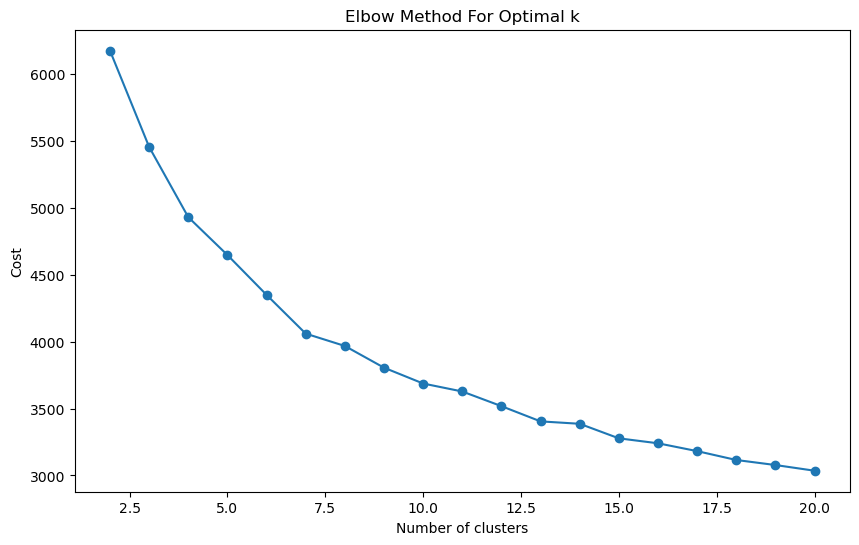

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), cost, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

### KMeans clustering

In [54]:
# K-means (from practise session)

from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=7, seed=42)
model = kmeans.fit(pca_result) # What shape should transformed_data be?

In [55]:
# Create the clusters using the model
clusters = model.transform(pca_result)

In [56]:
# Evaluating: the silhouette value

from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clusters)
print('Silhouette with squared euclidean distance = ', silhouette)

Silhouette with squared euclidean distance =  0.24744011205607538


## Search engine

In [58]:
# Recommender function

# Some ideas:
# https://asdkazmi.medium.com/ai-movies-recommendation-system-with-clustering-based-k-means-algorithm-f04467e02fcd
# https://www.activestate.com/blog/exploring-k-means-clustering-in-big-data-using-python/

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import lit

def cosine_similarity(v1, v2):
    return float(v1.dot(v2) / (v1.norm(2) * v2.norm(2)))


def recommend_papers(title, N):
    return None

# Example usage
top_papers = recommend_papers("adaboost", 5)
print(top_papers)


None
